In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

from scipy.integrate import odeint
from scipy.optimize import curve_fit

import scipy.stats as stats

## Parameter estimation of Linear ODE system





In [2]:
#Elimates the left and top lines and ticks in a matplotlib plot
def PlotStyle(Axes,Title):
    
    Axes.spines['top'].set_visible(False)
    Axes.spines['right'].set_visible(False)
    Axes.spines['bottom'].set_visible(True)
    Axes.spines['left'].set_visible(True)
    Axes.xaxis.set_tick_params(labelsize=14)
    Axes.yaxis.set_tick_params(labelsize=14)
    Axes.set_title(Title)

In [3]:
#Performs the dot produt to make the model 
def MakeModel(MatrixCoeficients,InitialConditions):
    
    return np.dot(MatrixCoeficients,InitialConditions)

#### Model A : Damped oscillations

$\frac{\partial^2 f(t)}{\partial t^2} + \alpha \frac{\partial f(t)}{\partial t} + \beta f(t) = 0 \\ f(0)=f_{0} \\\frac{\partial f(0)}{\partial t} = f_{0} $

Convert to first order ODE:

$u = \frac{\partial f}{\partial t}  \\ \frac{\partial u}{\partial t} = -\alpha u - \beta f(t) $
$\newcommand{\icol}[1]{% inline column vector
  \left(\begin{smallmatrix}#1\end{smallmatrix}\right)%
}$
$\frac{d}{dt}  \icol{u\\f} = \bigl( \begin{smallmatrix}-\alpha & -\beta\\ 1 & 0\end{smallmatrix}\bigr)   \icol{u\\f} $



In [84]:
SolverTime=np.linspace(0,20,num=150)
#Parameters for Model A
alpha = 0.4
beta = 1

#Matrix of coeficients for model A
#Model A is refered in this script as model 01
def MakeModelMatrix01(Alpha,Beta):
    
    Matrix=np.zeros((2,2))

    Matrix[0,0]=-Alpha
    Matrix[0,1]=-Beta
    Matrix[1,0]=1
    
    return Matrix

#Integrating Model A
Matrix01 = MakeModelMatrix01(alpha,beta)
#Initial conditions: value of f(0) and u(0)
Init = np.array([10,10])

def SODE(InitialConditions,t):
    return MakeModel(Matrix01,InitialConditions)

Solution=odeint(SODE,Init,SolverTime)
    



In [85]:
# Solution

In [86]:
# Solution

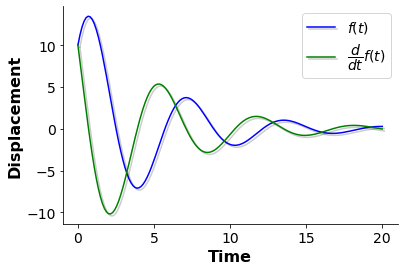

In [87]:
#Visualization
DerivativeLabel=r'$\dfrac{d}{dt} f(t) $'
SolutionLabel=r'$f(t)$'

plt.plot(SolverTime,Solution[:,1],'b-',label=SolutionLabel,path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(SolverTime,Solution[:,0],'g-',label=DerivativeLabel,path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time',fontsize=16,fontweight='bold')
plt.ylabel('Displacement',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)

ax=plt.gca()
PlotStyle(ax,'')

#### Model B: Concentration of compounds A,B,C in a reaction (parameters k1,k2,k3)

$\frac{\partial [A]}{dt} = -k_{1}[A] + k_{3}[B] \\$
$\frac{\partial [B]}{dt} = k_{1}[A] - k_{2}[B] - k_{3}[B]$




$\frac{\partial [C]}{dt} = k_{2}[B]$

In [88]:
SolverTime=np.linspace(0,20,num=150)

#Model B Parameters
k1=0.3
k2=0.25
k3=0.1

#Coeficients matrix for model B
#Model B is refered as model02
#Coeficients matrix for model B
#Model B is refered as model02
def MakeModelMatrix02(K1,K2,K3):
    
    Matrix=np.zeros((3,3))

    Matrix[0,0]=-K1
    Matrix[0,1]=K3

    Matrix[1,0]=K1
    Matrix[1,1]=-(K2+K3)

    Matrix[2,1]=K2
    
    return Matrix

Matrix02=MakeModelMatrix02(k1,k2,k3)
InitialConditions=[5,0,0]  #Let C and B have 0 concentrations at t=0

def KineticsSystem(InitialConditions,t):
    
    return MakeModel(Matrix02,InitialConditions)

SystemSolution=odeint(KineticsSystem,InitialConditions,SolverTime)

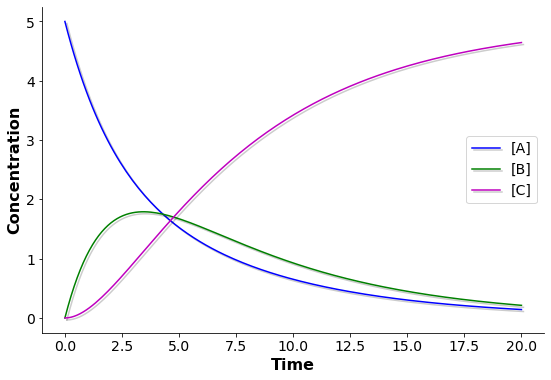

In [89]:

###############################################################################
#                    Visualization
###############################################################################

plt.figure(3,figsize=(9,6))

plt.plot(SolverTime,SystemSolution[:,0],'b-',label='[A]',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(SolverTime,SystemSolution[:,1],'g-',label='[B]',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(SolverTime,SystemSolution[:,2],'m-',label='[C]',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)

ax=plt.gca()
PlotStyle(ax,'')

### Parameter Estimation

In [90]:
#Let's assume we measure the displacement f(t) for Model A
#Let's assume we measure concentration of compound C for Model B

In [91]:
#Element wise sum of two iterables of the same size, name makes reference to the output rather than the process
def MakeNoisyData(Data,Noise):
    
    return [val+cal for val,cal in zip(Data,Noise)]

WhiteNoise=[np.random.uniform(low=-1,high=1)*3.0 for val in Solution[:,1]]
WhiteSignal=MakeNoisyData(Solution[:,1],WhiteNoise) #We measure positions hence Solution[:,1]

In [96]:
###############################################################################
#                              ODE fitting  
###############################################################################

#Model A
#Function for parameter estimation
#CurrentState: [u(t),f(t)]
def ModelSolver01(t,Alpha,Beta,InitialStateVector):
    
    cAlpha=Alpha
    cBeta=Beta
    cInit=InitialStateVector
    
    cMatrix=MakeModelMatrix01(cAlpha,cBeta)
    
    def LocalModel(cInit,t):
        
        return MakeModel(cMatrix,cInit)
    
    Solution=odeint(LocalModel,cInit,t)
    
    return Solution[:,1]

def ModelSolution01(t,Alpha,Beta):
    
    return ModelSolver01(t,Alpha,Beta,Init) #Remember "Init" is [u(0) f(0)]
    
Model01Params=curve_fit(ModelSolution01,SolverTime,WhiteSignal)

In [97]:
Model01Params  #Remember, true values are: alpha = 0.4, beta = 1

(array([0.43741073, 0.98905751]),
 array([[0.0007001 , 0.00014393],
        [0.00014393, 0.00043535]]))

In [98]:
#Fit solution

fAlpha=Model01Params[0][0]
fBeta=Model01Params[0][1]

FitSolutionA=ModelSolution01(SolverTime,fAlpha,fBeta)

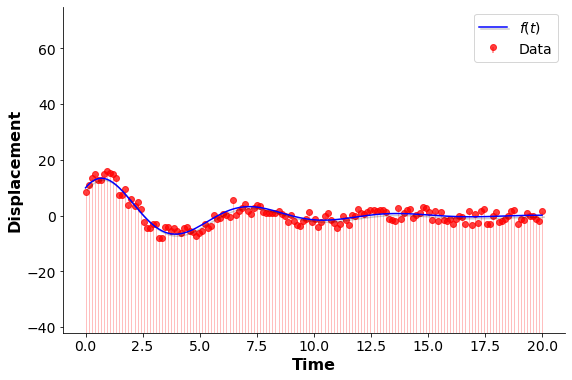

In [99]:
#Visualization
plt.figure(2,figsize=(9,6))

(markers, stemlines, baseline) = plt.stem(SolverTime, WhiteSignal,bottom=-42,label='Data',basefmt=" ")
plt.setp(stemlines, linestyle="-", color="red", linewidth=0.5,alpha=0.5 )
plt.setp(markers, color="red",alpha=0.75 )

plt.plot(SolverTime,FitSolutionA,'b-',label=SolutionLabel,path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
    
plt.xlabel('Time',fontsize=16,fontweight='bold')
plt.ylabel('Displacement',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)

plt.ylim(-42,75)

ax=plt.gca()
PlotStyle(ax,'')

In [149]:
# Model B
###############################################################################
#                            Data Generation
###############################################################################

WhiteNoise=[np.random.uniform(low=-1,high=1)/4 for val in SystemSolution[:,2]]
WhiteSignal=MakeNoisyData(SystemSolution[:,2],WhiteNoise) #We measure concentrations of C hence SystemSolution[:,2]

###############################################################################
#                              ODE fitting  
###############################################################################

In [237]:
def ModelSolver02(t,K1,K2,K3,InitialConditions):
    
    cK1=K1
    cK2=K2
    cK3=K3
    
    cInit=InitialConditions
    
    cMatrix=MakeModelMatrix02(cK1,cK2,cK3)
    
    def LocalModel(cInit,t):
        
        return MakeModel(cMatrix,cInit)
    
    Solution=odeint(LocalModel,cInit,t)
    
    return Solution[:,2]

def ModelSolution02(t,K1,K2,K3):
    
    return ModelSolver02(t,K1,K2,K3,InitialConditions)   #Remember we set InitialConditions=[5,0,0]
    
# p0 = [np.random.uniform(low=0.0,high=0.5) for i in np.arange(3)]    
Model02Params=curve_fit(ModelSolution02,SolverTime,WhiteSignal) #curve_fit(ModelSolution02,SolverTime,WhiteSignal,p0)

fK1=Model02Params[0][0]
fK2=Model02Params[0][1]
fK3=Model02Params[0][2]

FitSolutionB=ModelSolution02(SolverTime,fK1,fK2,fK3) #the fitted curve

In [238]:
np.arange(3)

array([0, 1, 2])

In [239]:
Model02Params[1]  #VERY large uncertainties, need to study cause more

array([[ 5459016.84959289, -9075050.89009315,  3616020.3616762 ],
       [-9075050.89009315, 15086333.47876535, -6011259.84856777],
       [ 3616020.3616762 , -6011259.84856776,  2395230.42656023]])

In [240]:
np.sqrt(np.diag(Model02Params[1]))

array([2336.45390487, 3884.11295906, 1547.65319971])

In [241]:
#True Model B Parameters
#k1=0.3
#k2=0.25
#k3=0.1

fK1  #k1 estimate

0.2145958263232675

In [242]:
fK2  #k2 estimate

0.35711856547653714

In [243]:
fK3  #k3 estimate

0.0815681947451658

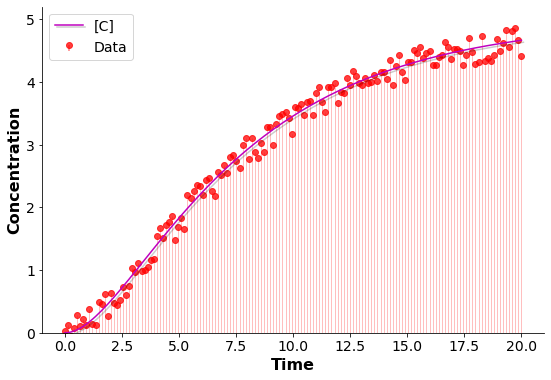

In [244]:
# Visualization
###############################################################################

plt.figure(4,figsize=(9,6))

(markers, stemlines, baseline) = plt.stem(SolverTime, WhiteSignal,bottom=0,label='Data',basefmt=" ")
plt.setp(stemlines, linestyle="-", color="red", linewidth=0.5,alpha=0.5 )
plt.setp(markers, color="red",alpha=0.75 )

SolutionLabel='[C]'
plt.plot(SolverTime,FitSolutionB,'m-',label=SolutionLabel,path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
    
plt.xlabel('Time',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)

plt.ylim(0,5.2)

ax=plt.gca()
PlotStyle(ax,'')

In [245]:
###############################################################################
#                    Residuals Statistical test  
###############################################################################

#Let's test if the noise added to generate the data and the residuals came from the same distribution. 
#If yes, the model accurately describes the data

ObRes=[signal-model for signal,model in zip(WhiteSignal,FitSolutionB)]

KS=stats.ks_2samp(ObRes,WhiteNoise)

print(KS)

KstestResult(statistic=0.12666666666666668, pvalue=0.18039483841127182)


In [ ]:
# p-value is greater than 0.05, so we accept the Null hypothesis (they come from the same distribution) at 5% significance

In [247]:
len(ObRes)

150

In [ ]:
#Null hypothesis: both samples are generated by the same distribution
#Alternative hypothesis: boths samples are generated by different distributions

In [252]:
# 1.52/np.sqrt(150) #KS test Critical Value for alpha=0.02 significance (see: http://oak.ucc.nau.edu/rh83/Statistics/ks1/)

0.12410748030101436